In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import helper
import metrics
import _init_paths
import torch
import torch.utils.data
from opts import opts
from lib.models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
from pytorch_unet_center_wh import train_model
import unet_models
import os,sys
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import helper
#import simulation
from tqdm import tqdm
import time
import copy
import numpy as np
import torch
import metrics
from metrics import MetricsCollection
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from test_model import test
from scipy.ndimage.measurements import label

In [12]:
class opts(object):
  def __init__(self):
    self.seed = 327
    self.dataset = 'shape'
    self.task = 'ctdet'
    self.device = 'cuda'
    self.shape_param = ''
    self.shape_param_value = ''
    self.data_dir = '/home/mehdi/CenterNet-master/data'
    self.batch_size = 20
    self.no_color_aug = True
    self.num_workers = 4
    self.keep_res = False
    self.pad = 127
    self.not_rand_crop = True
    self.scale = 0.4
    self.shift = 0.1
    self.flip = 0.5
    self.down_ratio = 1
    self.mse_loss = True
    self.gpus = 0
    self.gpus_str = '0'
    self.input_res = -1
    self.input_h = -1
    self.input_w = -1
    self.cat_spec_wh = True
    self.not_reg_offset = True
    self.reg_offset = not self.not_reg_offset
    self.save_dir = '/home/mehdi/CenterNet-master/MaskCenter_experimets'
    self.debug_dir = '/home/mehdi/CenterNet-master/experiments'
    self.trainval = True
    self.test_scales = '1'
    self.exp_id = 'default'
    self.debug = 0
    self.debugger_theme = 'white'
    self.fix_res = True
    self.flip_test =True
    #self.root_dir = os.path.join(os.path.dirname(__file__), '..', '..')
    #self.data_dir = os.path.join(self.root_dir, 'data')

In [13]:
opt = opts()

In [4]:
def train_model(model, optimizer, lr_scheduler, data_loader, device, max_epochs=1000): #loaders
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    has_waited = 0
    stop_training = False
    earlystop_patience = 500

    epoch_metrics = MetricsCollection()

    for epoch in range(max_epochs):
        print('Epoch {}/{}'.format(epoch, max_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
        #    if phase == 'train':
        #        model.train()  # Set model to training mode
        #    else:
        #        model.eval()  # Set model to evaluate mode

            batch_metrics = MetricsCollection()

            #########################
            # loader = loaders[phase]
            #pbar = tqdm(data_loader, total=len(data_loader), ncols=0)#, desc="Epoch {} {}".format(epoch, phase)
            for ind, (img_id, batch) in enumerate(data_loader): #data_loader


                for k in batch:
                    if k != 'meta':
                        batch[k] = batch[k].to(device=device, non_blocking=True)
                inputs,class_masks,center_masks,width_masks,height_masks =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap'] # loss_stats
                
                output, losses = model(inputs, class_masks, center_masks, width_masks, height_masks) #batch
                #loss = loss.mean()
                loss = losses['loss']
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            #pbar = tqdm(data_loader, total=len(data_loader), desc="Epoch {} {}".format(epoch, phase), ncols=0)
            # for i, (inputs, class_masks, center_masks, width_masks, height_masks) in enumerate(pbar):
            #########################




                #inputs = inputs.to(device)
                #class_masks = class_masks.to(device)
                #center_masks = center_masks.to(device)
                #width_masks = width_masks.to(device)
                #height_masks = height_masks.to(device)

                #optimizer.zero_grad()

                # compute output
                #with torch.set_grad_enabled(phase == 'train'):
                #    outputs, losses = model(inputs, class_masks, center_masks, width_masks, height_masks)

                #if phase == 'train':
                #    loss = losses['loss']
                #    loss.backward()
                #    optimizer.step()

                for k, v in losses.items():
                    batch_metrics.add(phase, k, v.item())
                #if phase =='train':
                #    pbar.set_postfix(**{k: "{:.5f}".format(meter.avg) for k, meter in batch_metrics[phase].items()})
            output_str= ''
            for key, meter in batch_metrics[phase].items():
                epoch_metrics.add(phase, key, meter.avg)
                if phase=='train':
                    output_str+= '{}_{}'.format(phase, key)
                    output_str+= ':'
                    output_str+=str(meter.avg)
                    output_str+= ' '
                    
                    #print('{}_{}'.format(phase, key), meter.avg)
            print(output_str)

            if phase == 'val' and (epoch% 10==0):
                # monitor the val metrics
                best_epoch_index = epoch_metrics['val']['loss'].best()[1]
                if best_epoch_index == epoch:
                    has_waited = 1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("Saving the best model state dict")
                else:
                    if has_waited >= earlystop_patience:
                        print("** Early stop in training: {} waits **".format(has_waited))
                        stop_training = True

                    has_waited += 1
                if type(lr_scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                    lr_scheduler.step(epoch_metrics['val']['loss'].value)
                else:
                    lr_scheduler.step()

        #print()  # end of epoch
        if stop_training:
            break

    #time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    #load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, './model_last.pth')
    print ('New model saved!')
    return model



In [5]:

def main():
  torch.manual_seed(opt.seed)
  Dataset = get_dataset(opt.dataset, opt.task)
  
  val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'), 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True)
      


  train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )
  #Mehdi
  ###############

  import models

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_class = Dataset.num_classes #6
  lr_factor = 0.1
  lr_patience = 1
  lr = 1e-4

  modelunet = unet_models.WidthHeightUNet(num_class).to(device)

  optimizer = torch.optim.Adam(modelunet.parameters(), lr=lr)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                            factor=lr_factor,
                                                          patience=lr_patience,
                                                            verbose=True)

  model = train_model(modelunet, optimizer, lr_scheduler, train_loader,device)
  return model  

In [6]:
trained_model = main()


==> initializing shapes val data.
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loaded val 800 samples
==> initializing shapes train data.
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded train 800 samples
Epoch 0/999


/home/mehdi/CenterNet-master/src/lib/datasets/sample/ctdet.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, plots = plt.subplots(1, 2,sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))
/home/mehdi/CenterNet-master/src/lib/datasets/sample/ctdet.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, plots = plt.subplots(1, 2,sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))
/home/mehdi/CenterNet-master/src/lib/datasets/sample/ctdet.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

train_bce_mask:0.33256397359073164 train_dice:0.9135572791099549 train_bce_center:0.1386220655636862 train_dice_center:0.7156868308782578 train_l2_width:0.03165092315757647 train_l2_height:0.027421765343751757 train_loss:2.15950283408165 


/home/mehdi/CenterNet-master/src/lib/datasets/sample/ctdet.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, plots = plt.subplots(1, 2,sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))
/home/mehdi/CenterNet-master/src/lib/datasets/sample/ctdet.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, plots = plt.subplots(1, 2,sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))
/home/mehdi/CenterNet-master/src/lib/datasets/sample/ctdet.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i


Saving the best model state dict
Epoch 1/999


/home/mehdi/CenterNet-master/src/lib/datasets/sample/ctdet.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, plots = plt.subplots(1, 2,sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))
/home/mehdi/CenterNet-master/src/lib/datasets/sample/ctdet.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, plots = plt.subplots(1, 2,sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))
/home/mehdi/CenterNet-master/src/lib/datasets/sample/ctdet.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

KeyboardInterrupt: 

In [14]:

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = np.clip(inp, 0, 1)
    #inp = (inp * 255).astype(np.uint8) 
    
    return inp

In [15]:
trained_model = torch.load('model_last-mc800-1000aug.pth')

==> initializing shapes val data.
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loaded val 800 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[]
0 0
[]
0 0
[]
0 0
[]
0 0
[(11, 6, 10, 14)]
0 1


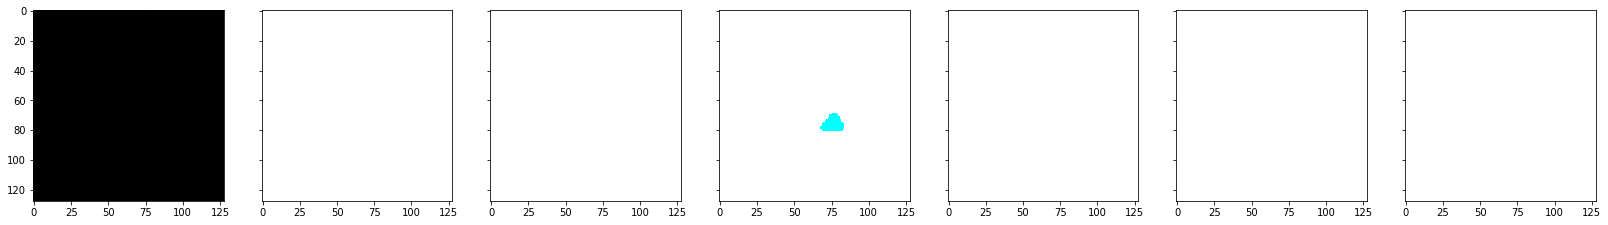

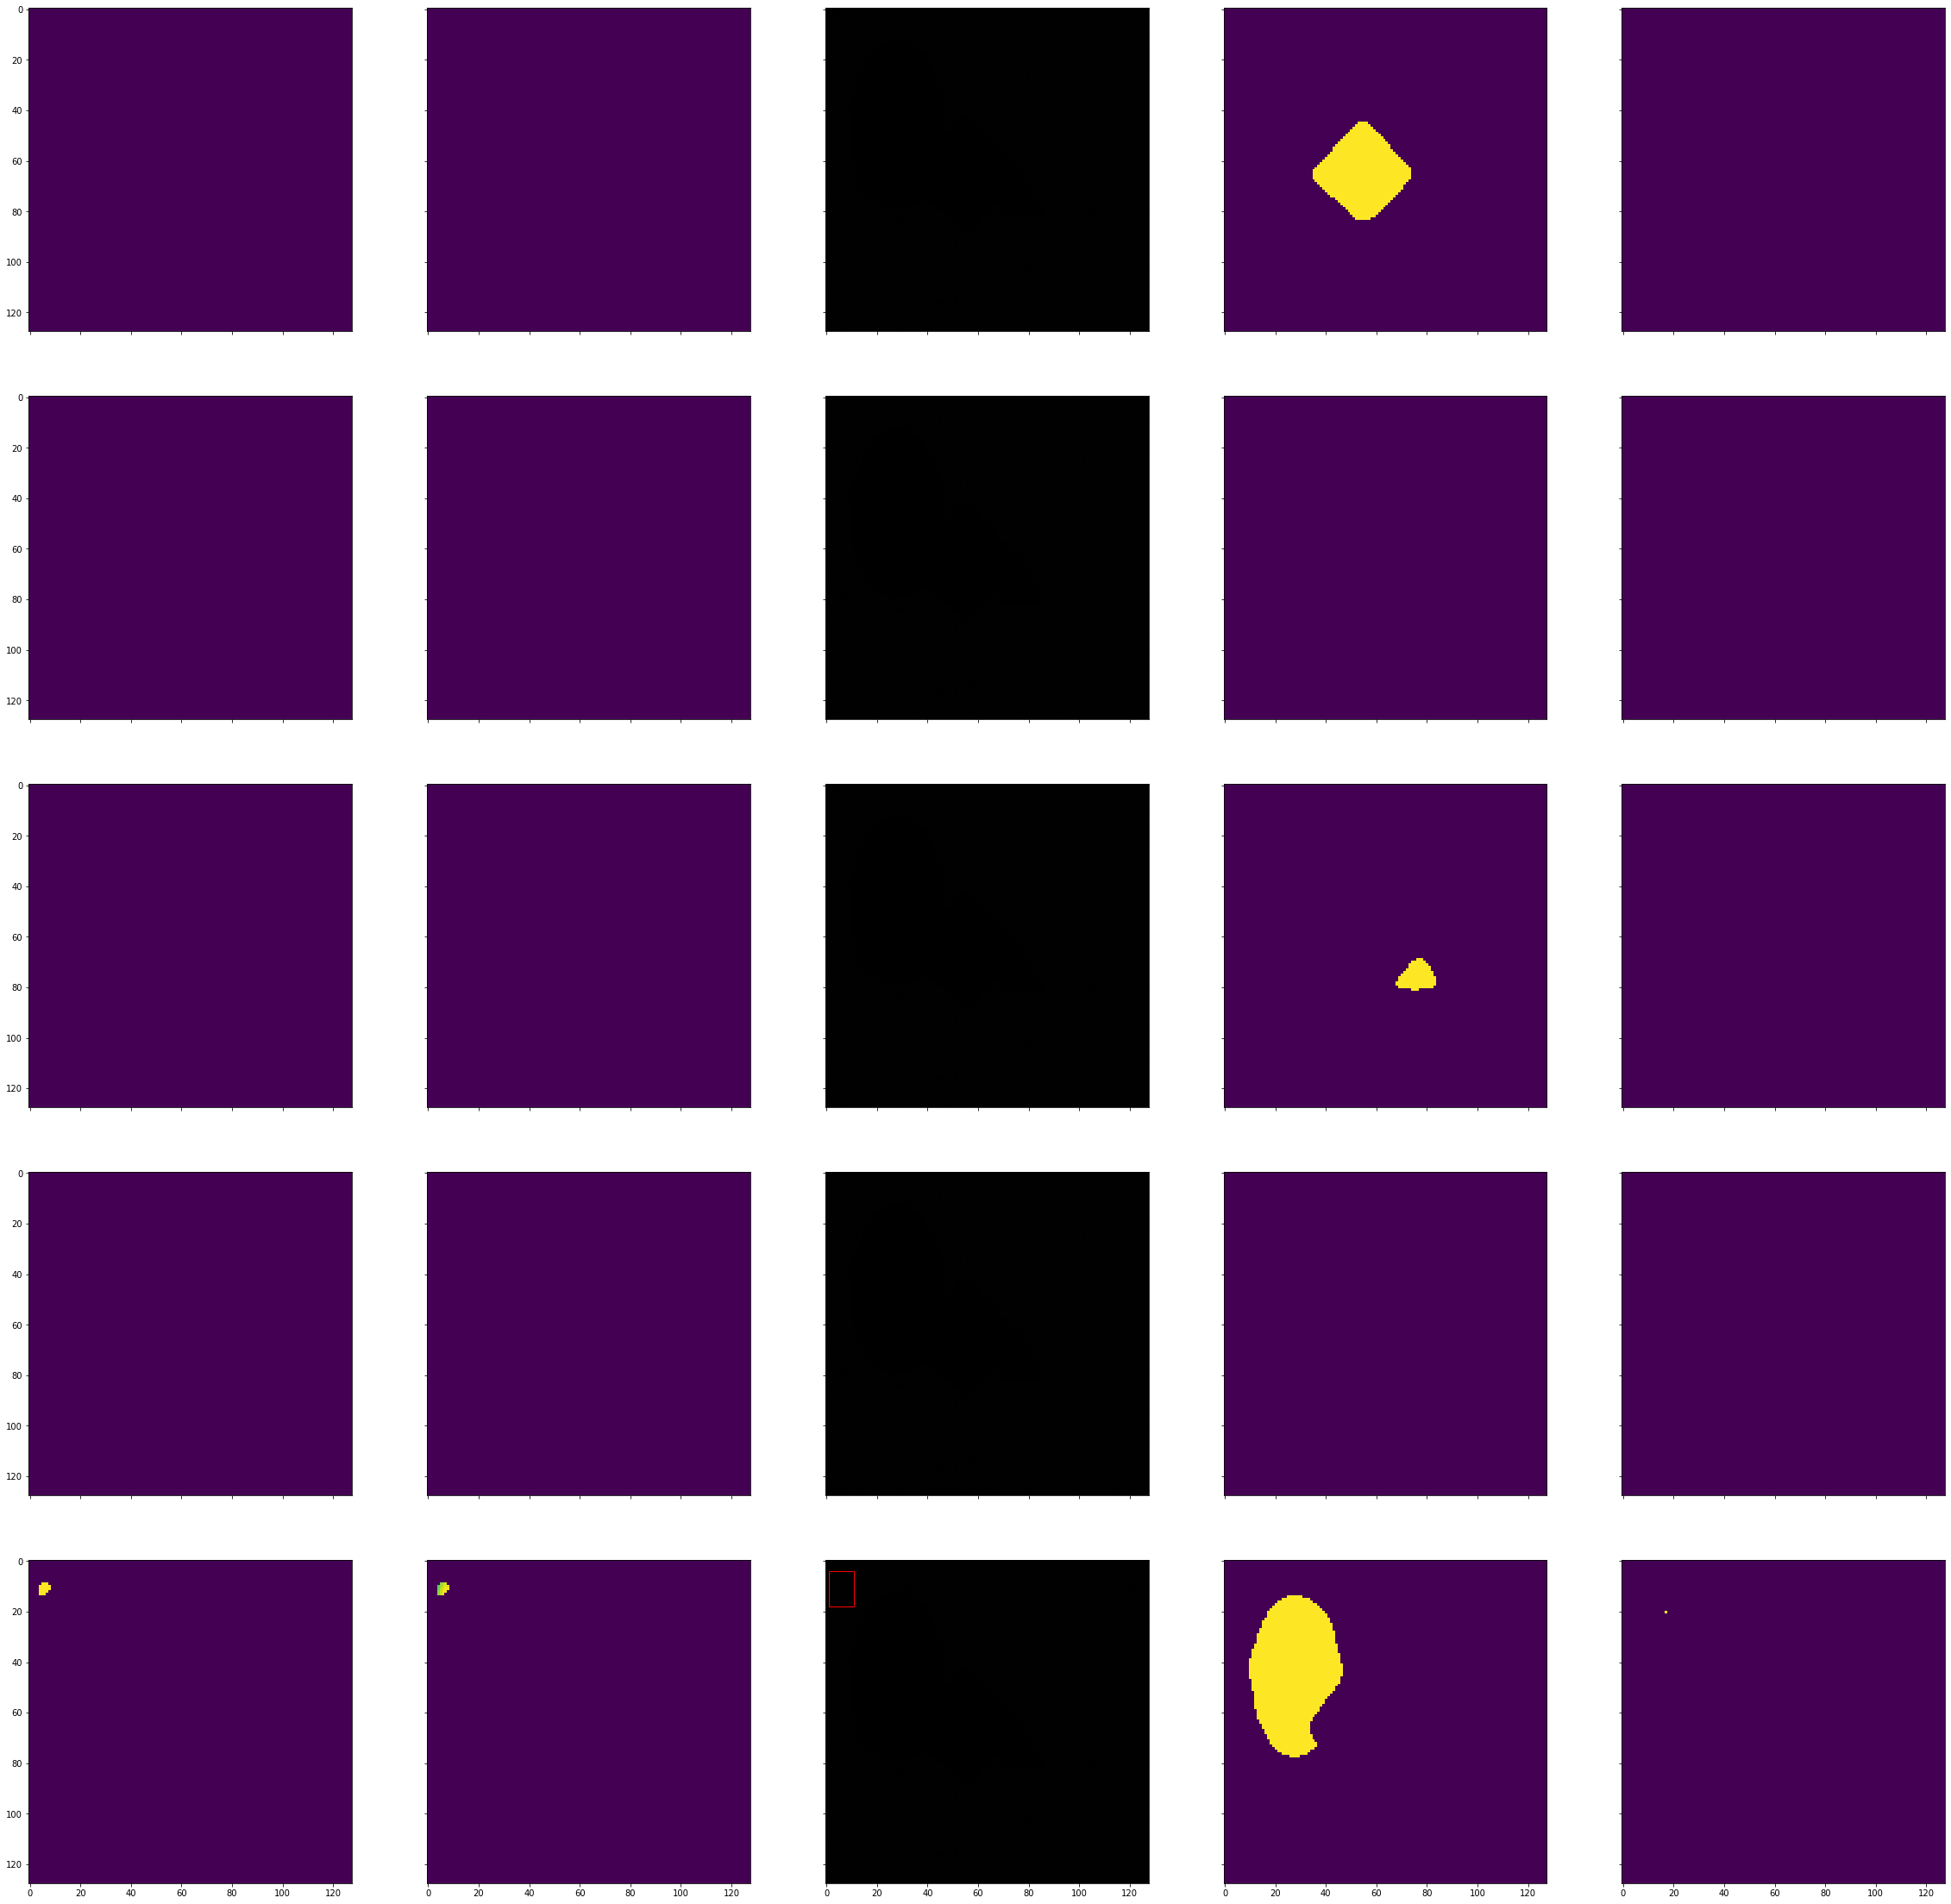

In [18]:
import math
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.measurements import label  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 5
n_class=5
    
Dataset = get_dataset(opt.dataset, opt.task)
  
val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'), 
      batch_size=1, 
      shuffle=True,
      num_workers=1,
      pin_memory=True)

model=trained_model  
    
model.eval()   # Set model to evaluate mode

#test_dataset = SimDataset(1, n_class, transform = trans)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
        
#batch  = next(iter(val_loader))
img_id, batch = next(iter (val_loader))
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=device, non_blocking=True)
inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']
pred = model(inputs, labels_mask, labels_center, labels_width, labels_height )
pred = pred[0]



#inputs = inputs.to(device)
# labels_mask = labels_mask.to(device)
# labels_center = labels_center.to(device)



# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x)/255 for x in inputs.cpu()]


# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x/255, n_class) for x in labels_mask]

# Map each channel (i.e. class) to each color
target_centers_rgb = [helper.masks_to_colorimg(x/255, n_class) for x in labels_center]

for i in [pred]:
    pred_masks = i['class_masks'].data.cpu().numpy()
    pred_centers = i['center_masks'].data.cpu().numpy()
    pred_widths = i['width_masks'].data.cpu().numpy()
    pred_heights = i['height_masks'].data.cpu().numpy()

    mask = pred_centers.copy() 
    mask[mask<0]=0
    mask[mask>0]=1
    
    #import pdb; pdb.set_trace()
    pred_masks_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_masks]
    pred_centers_rgb = [helper.masks_to_colorimg(x, n_class) for x in mask] # pred_centers
    pred_widths_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_widths * mask]
    pred_heights_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_heights * mask]



# Left: Input image, Right: Target mask (Ground-truth)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, target_centers_rgb, pred_masks_rgb, pred_centers_rgb, pred_widths_rgb, pred_heights_rgb])


# -------

inp = np.copy(inputs.cpu())
img = np.copy(inp[0])
# img = img.reshape((192,192,3))
img = np.transpose(img,[1,2,0])/255
# img = img(:,:,[0])




f, plots = plt.subplots(n_class, 5, sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))

ret = {}
ret['results'] = {}
for i in range(1,n_class+1):
    ret['results'][i] = []  

for i in range(n_class):
    a2 = np.copy(pred_centers[0,i,:,:])
    a2[a2<0]=0
    a2[a2>0]=1
    plots[i,0].imshow(a2)

    a4 = np.copy(pred_widths[0,i,:,:])     
    a4 = a4*a2 #.numpy()
    plots[i,1].imshow(a4)


    a5 = np.copy(pred_heights[0,i,:,:])     
    a5 = a5*a2 #.numpy()    

# finding connected components
    from scipy.ndimage.measurements import label  
    structure = np.ones((3, 3), dtype=np.int)
    labeled, ncomponents = label(a4, structure)
    indices = np.indices(a4.shape).T[:,:,[1, 0]]

    ax = plots[i,2] #plt.subplots(1)
    ax.imshow(img)
    coords = []
    for c in range(ncomponents):
        a = indices[labeled == c+1]
        x, y = (np.min(a[:,0]) + np.max(a[:,0]))//2, (np.min(a[:,1]) + np.max(a[:,1]))//2
        w, h = int(a4[x,y])+1, int(a5[x,y])+1
        coords.append( (x, y , w, h) )    
        rect = patches.Rectangle((y-w//2, x-h//2), w, h, linewidth=1, edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    
    print((coords))
    tt = []
    for u in range(ncomponents):
        x, y = coords[u][:2]
        confidences = torch.softmax(torch.tensor(pred_centers[0,:,x,y]), dim=0)
        tt += [list(coords[u]) + [confidences[i].tolist()]]
    tt = np.array(tt, np.float32)
    
    ret['results'][i] = tt
    
    #semantic_mask = np.zeros(pred_masks.shape[2:])
    pred_masks_class = pred_masks[0,i,...]
    pred_masks_class[pred_masks_class<0] = 0 #pred_masks_class
    pred_masks_class[pred_masks_class>0] = 1

    #for box in coords:
    #    x, y, w, h = box
    #    w , h = w//2+1, h//2+1
    #    semantic_mask[y-h:y+h, x-w:x+w]  = 1
    plots[i,3].imshow(pred_masks_class) # * semantic_mask )  


    instance_mask = np.zeros(pred_masks.shape[2:])
    pred_masks_class = pred_masks[0,i,...]
    pred_masks_class[pred_masks_class<0] = 0
    pred_masks_class[pred_masks_class>0] = 1
    xx = np.zeros(pred_masks.shape[2:], dtype=np.int)
    cc = 1
    
    im_w, im_h = pred_masks.shape[2:]
    
    for box in coords:
        x, y, w, h = box
        w , h = w//2+5, h//2+5
        x1, x2, y1, y2 = np.max([x-w, 0]), np.min([x+w, im_w]), np.max ([y-h, 0 ]), np.min([y+h, im_h])
        instance_mask = np.zeros(pred_masks.shape[2:])
        instance_mask[x1:x2, y1:y2]  = 1
        mm = np.zeros(pred_masks.shape[2:], dtype=np.int)
        mm = pred_masks_class.astype(int) * instance_mask.astype(int) 
        mm = mm * cc
        xx = xx + mm
        xx[xx>cc] = cc
        cc += 1

        
        
#     xx = np.reshape(xx, [1,xx.shape[0], xx.shape[1]])
#     xx = xx[0,0,:,:]
    xx = xx.astype(int)
    print(np.min(xx), np.max(xx))
    plots[i,4].imshow(xx)
    #plots[i,4].imshow(helper.masks_to_colorimg3(xx))

In [7]:

def get_res(pred,n_class):
    
    for i in [pred]:
        pred_masks = i['class_masks'].data.cpu().numpy()
        pred_centers = i['center_masks'].data.cpu().numpy()
        pred_widths = i['width_masks'].data.cpu().numpy()
        pred_heights = i['height_masks'].data.cpu().numpy()
    
    ret = {}
    ret['results'] = {}
    for i in range(1,n_class+1):
        ret['results'][i] = []  

    for i in range(n_class):
        a2 = np.copy(pred_centers[0,i,:,:])
        a2[a2<0]=0
        a2[a2>0]=1
    
        a4 = np.copy(pred_widths[0,i,:,:])     
        a4 = a4*a2 #.numpy()
   

        a5 = np.copy(pred_heights[0,i,:,:])     
        a5 = a5*a2 #.numpy()    
      
        structure = np.ones((3, 3), dtype=np.int)
        labeled, ncomponents = label(a4, structure)
        indices = np.indices(a4.shape).T[:,:,[1, 0]]

    
        coords = []
        for c in range(ncomponents):
            a = indices[labeled == c+1]
            x, y = (np.min(a[:,0]) + np.max(a[:,0]))//2, (np.min(a[:,1]) + np.max(a[:,1]))//2
            w, h = int(a4[x,y])+1, int(a5[x,y])+1
            coords.append( (x,y,w,h) )
            
        
        #import pdb
        #pdb.set_trace()
        tt = []
        for u in range(ncomponents):
            #print (coords[u],'n_component')
            x, y, w, h = coords[u]
            confidences = torch.softmax(torch.tensor(pred_centers[0,:,x,y]), dim=0)
            tt += [list((y-w/2 , x-h/2, y+w/2, x+h/2 )) + [confidences[i].tolist()]]
        tt = np.array(tt, np.float32)
    
        ret['results'][i+1] = tt
    return ret


In [9]:
n_class = 5  
Dataset = get_dataset(opt.dataset, opt.task)

val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=1,#opt.batch_size, 
      shuffle=True,
      num_workers=1,#opt.num_workers,
      pin_memory=True,
      drop_last=True
)
  
#val_loader = torch.utils.data.DataLoader(
#      Dataset(opt, 'val'), 
#      batch_size=1, 
#      shuffle=True,
#      num_workers=1,
#      pin_memory=True)

model=trained_model  
    
model.eval()   # Set model to evaluate mode
results= {}
for ind, (img_id, batch) in enumerate(val_loader):
   #print(img_id)
   #import pdb; pdb.set_trace()
   # import ipdb; ipdb.set_trace()
    for k in batch:
        if k != 'meta':
            batch[k] = batch[k].to(device=device, non_blocking=True)
    inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']
    pred = model(inputs, labels_mask, labels_center, labels_width, labels_height )
    pred = pred[0] 
    #ret = detector.run(pre_processed_images)
 
    ret = get_res(pred, n_class)

    results[img_id.numpy().astype(np.int32)[0]] = ret['results']
    #Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    #for t in avg_time_stats:
    #    avg_time_stats[t].update(ret[t])
    #     Bar.suffix = Bar.suffix + '|{} {tm.val:.3f}s ({tm.avg:.3f}s) '.format(
    #   t, tm = avg_time_stats[t])
    #bar.next()
#bar.finish()
#Dataset = get_dataset(opt.dataset, opt.task)
dataset = Dataset(opt,'test')
dataset.run_eval(results, opt.save_dir)
#dataset.run_eval(results, opt.save_dir)

==> initializing shapes train data.
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Loaded train 8000 samples
==> initializing shapes test data.
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Loaded test 8000 samples
Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.40s).
Accumulating evaluation results...
DONE (t=1.41s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.839
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall    

In [185]:
results[0]

{1: array([], dtype=float32),
 2: array([[40., 27., 28., 32.,  1.]], dtype=float32),
 3: array([[40.5, 59. , 45. , 44. ,  1. ]], dtype=float32),
 4: array([], dtype=float32),
 5: [],
 0: array([], dtype=float32)}

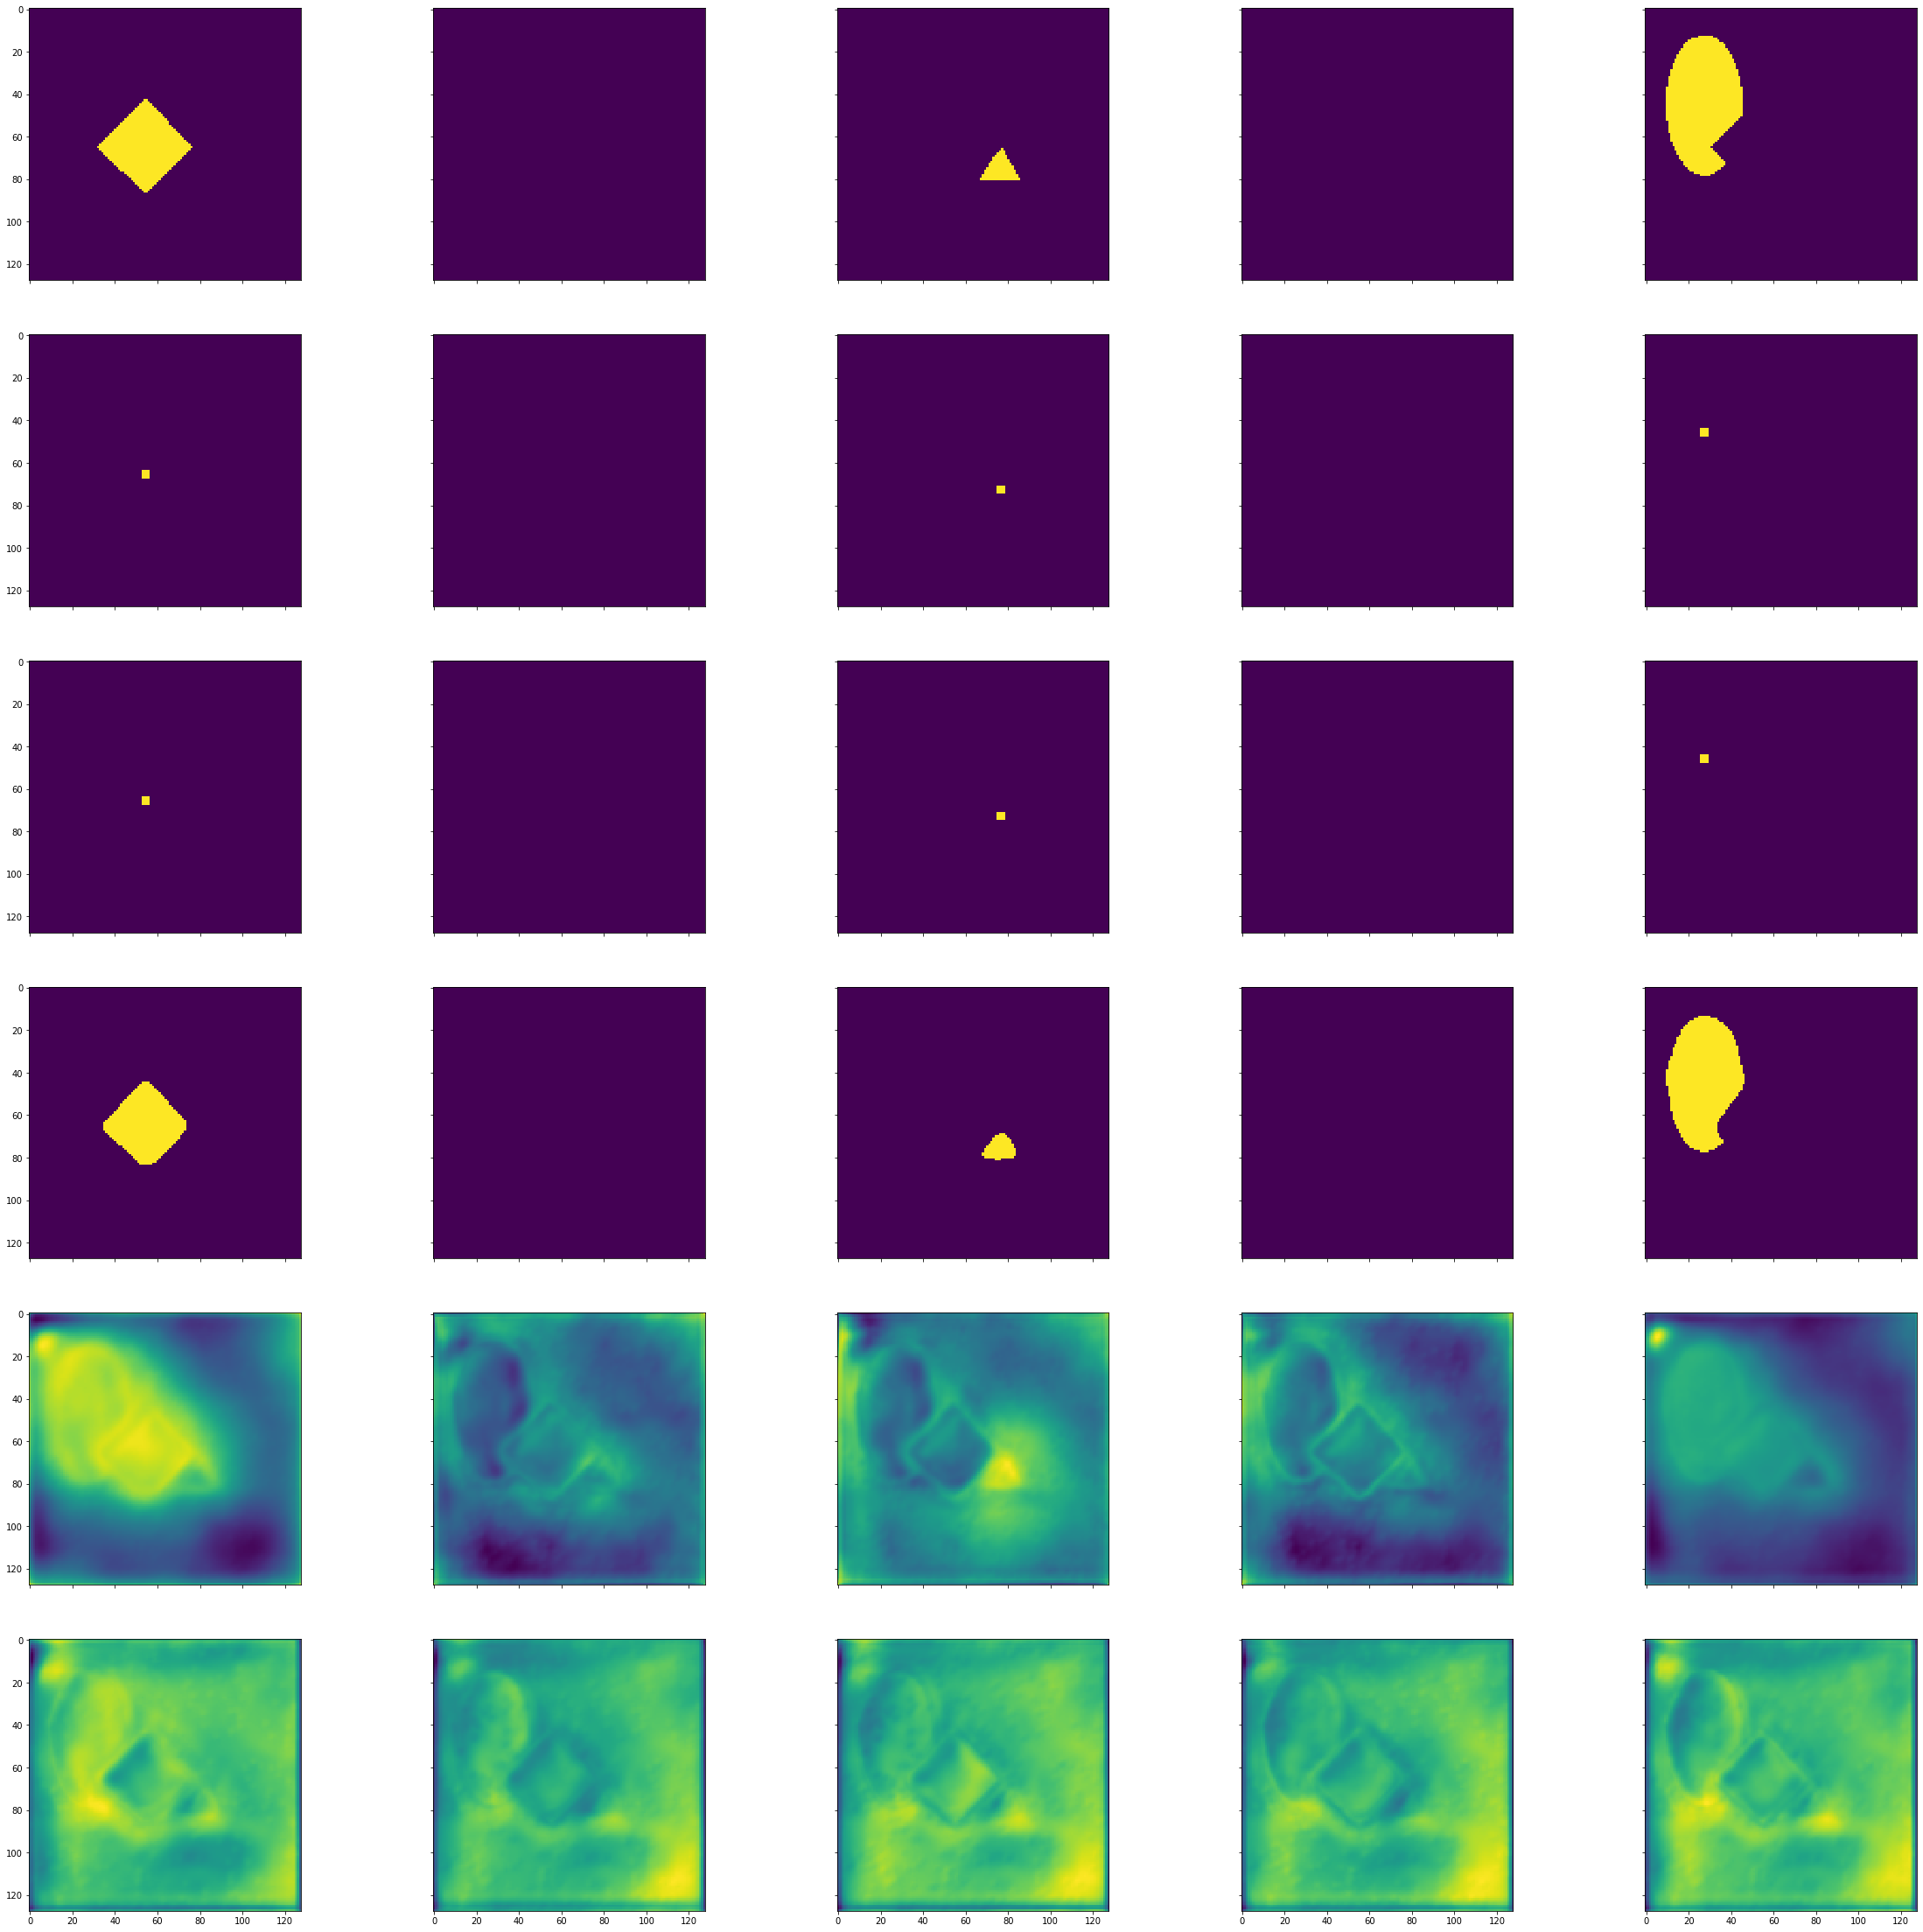

In [19]:
f, plots = plt.subplots(6, 5, sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))
for i in range(n_class):
   # plt.figure()
    plots[0,i].imshow(labels_mask[0,i])
    plots[1,i].imshow(labels_center[0,i])
    plots[2,i].imshow(labels_width[0,i])
    plots[3,i].imshow(pred_masks[0,i])
    plots[4,i].imshow(pred_centers[0,i])
#    xx = pred_centers[0,i]
#    xx[xx>0] = 1
#    xx[xx<0] = 0
    #plots[4,i].imshow(xx)

    plots[5,i].imshow(pred_widths[0,i])
    

    

    


In [149]:
Dataset = get_dataset(opt.dataset, opt.task)
dataset = Dataset(opt,'test')
dataset.run_eval(results, opt.save_dir)
#len(results)

==> initializing shapes test data.
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
Loaded test 8000 samples
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.48s).
Accumulating evaluation results...
DONE (t=1.61s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Ave

In [72]:
np.sort(pred_centers[-1,...][4].ravel())

array([-277.41052 , -277.16885 , -276.83246 , ...,   42.545418,
         42.914165,   46.0129  ], dtype=float32)

In [4]:
#plt.imshow(pred_masks[0].transpose((1, 2, 0)))
import math
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.measurements import label  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 3
n_class=3
    
Dataset = get_dataset(opt.dataset, opt.task)
  
val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'), 
      batch_size=1, 
      shuffle=True,
      num_workers=1,
      pin_memory=True)
batch  = next(iter(val_loader))
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=device, non_blocking=True)
inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']

k =1
plt.imshow(pred_masks[0,k])

==> initializing shapes val data.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded val 700 samples


NameError: name 'pred_masks' is not defined

In [20]:
pred

tensor([432])

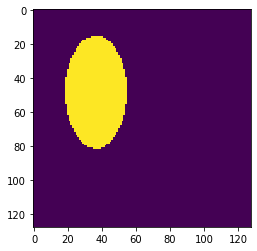

In [26]:
k = 4
plt.imshow(labels_mask[0,k])

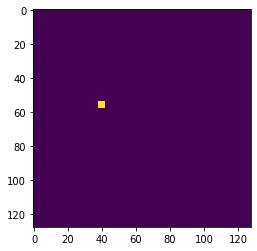

In [28]:
k=3
plt.imshow(labels_height[0,k])


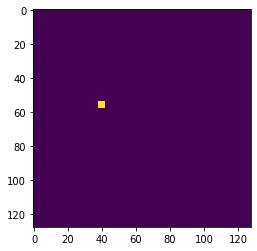

In [32]:
k = 3
plt.imshow(labels_width[0,k])

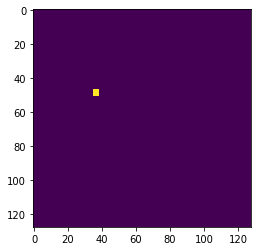

In [31]:
k = 4
plt.imshow(labels_center[0,k])

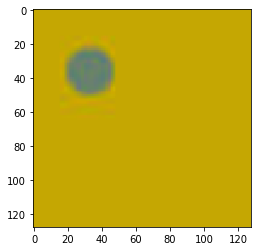

In [131]:
plt.figure()
#plt.imshow(reverse_transform(inputs[0].cpu()))
#plt.imshow(reverse_transform(labels_mask[0].cpu()))
#plt.imshow(reverse_transform(labels_center[0].cpu()))
#plt.imshow(reverse_transform(labels_width[0].cpu()))
#plt.imshow(reverse_transform(labels_height[0].cpu()))
plt.imshow(inputs[0].cpu().numpy().transpose((1, 2, 0))/255) #.dtype

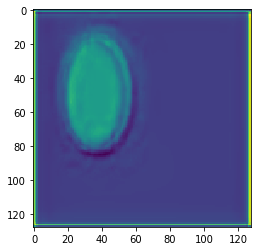

In [37]:
k = 4
plt.imshow(pred_widths[0,k])

In [59]:
l.shape

(1, 5, 128, 128)

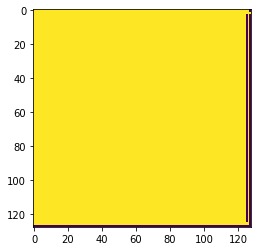

In [45]:
plt.imshow(pred_masks[0,4])